# Cassava Leaf Disease Classification - Kaggle Competition 2020 

## Descrição

Como o Segundo maior provedor de carboidratos na África, a mandioca é um alimento fundamental pois consegue resistir a condições adversas.
Pelo menos 80% das fazendas familiares na África Subsaariana cultivam esta raiz rica em amido,
mas as doenças virais são as principais fontes de baixos rendimentos. Com a ajuda da ciência de dados, pode ser possível identificar doenças comuns para que possam ser tratadas.
Os métodos existentes de detecção de doenças exigem que os agricultores solicitem a ajuda de especialistas agrícolas financiados pelo governo para inspecionar visualmente e diagnosticar as plantas. Isso acaba sendo muito trabalhoso, com baixo suprimento e preço muito caro. Como um desafio adicional, soluções eficazes para os agricultores devem ter um bom desempenho sob restrições significativas, uma vez que os agricultores africanos só podem ter acesso a câmeras de qualidade móvel com baixa largura de banda.
Nesta competição, apresentamos um conjunto de dados de 21.367 imagens rotuladas coletadas durante uma pesquisa regular em Uganda. A maioria das imagens foi coletada por agricultores tirando fotos de seus jardins e anotadas por especialistas do National Crops Resources Research Institute (NaCRRI) em colaboração com o laboratório de IA da Makerere University, Kampala. Este é um formato que representa de forma mais realista o que os agricultores precisam diagnosticar na vida real.
A nossa tarefa é classificar cada imagem de mandioca em quatro categorias de doenças ou uma quinta categoria indicando uma folha saudável. Com a nossa ajuda, os agricultores podem ser capazes de identificar rapidamente as plantas doentes, potencialmente salvando suas safras antes que elas causem danos irreparáveis.

Nessa competição irei utilizar uma técnica chamada de Aprendizagem de transferência (Transfer Learning),já tinha visto antes, mas eu vi bem mais explicado no workshop do DoWhile2020, com o Developer Advocate do Google, Luiz Gustavo Martins, e vamos ver qual será a acurácia do modelo.

# Classes 

* 0 - "Cassava Bacterial Blight (CBB)
* 1 - "Cassava Brown Streak Disease (CBSD)"
* 2 - "Cassava Green Mottle (CGM)"
* 3 - "Cassava Mosaic Disease (CMD)"
* 4 - "Healthy"

# Importando as bibliotecas necessárias

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import os
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"

In [2]:
BATCH_SIZE = 32
img_height = 224
img_width = 224
IMAGE_SIZE = (img_width, img_height)



In [12]:
# Carregando o modelo pré-treinado, irei utilizar o Inception_v3, pois é um modelo utilizado para plantas e animais

feature_extractor_model ="https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4"

In [13]:
# Criando a feature extractor, e freezando as variáveis

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(img_height, img_width, 3), trainable=False)

In [6]:
# carregando o ImageDataGenerator, para o data augmentation, que nada mais é que aumentar o número de imagens fazendo várias modificações nelas, eu utilizei o aumento de zoom, rotação de imagem,
# giro horizontal e etc.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_train = ImageDataGenerator(rescale=1/255., horizontal_flip=True, zoom_range=0.7,  width_shift_range=.25, height_shift_range=.25, rotation_range=.13)
data_gen_val = ImageDataGenerator(rescale=1/255.)

In [7]:
# pegando as imagens de treino, e validação pelo diretorio, vemos que temos 5 classes

train_generator = data_gen_train.flow_from_directory('./train', target_size=(224,224), batch_size=100, color_mode='rgb', shuffle=True, class_mode='sparse')
validation = data_gen_val.flow_from_directory('./validation', target_size=(224,224), batch_size=100, color_mode='rgb', shuffle=False, class_mode='sparse')

Found 16280 images belonging to 5 classes.
Found 5117 images belonging to 5 classes.


In [9]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(100, 224, 224, 3)
(100,)


In [14]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(100, 2048)


In [15]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(train_generator.num_classes,
                        kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
base_learning_rate = 0.005
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [22]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation.samples // validation.batch_size
history = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps)

Epoch 1/5
162/162 [==============================] - 1133s 7s/step - loss: 0.9485 - accuracy: 0.6587 - val_loss: 0.8569 - val_accuracy: 0.6690
Epoch 2/5
162/162 [==============================] - 684s 4s/step - loss: 0.8317 - accuracy: 0.6930 - val_loss: 0.8042 - val_accuracy: 0.6980
Epoch 3/5
162/162 [==============================] - 611s 4s/step - loss: 0.8021 - accuracy: 0.7033 - val_loss: 0.7747 - val_accuracy: 0.7122
Epoch 4/5
162/162 [==============================] - 721s 4s/step - loss: 0.7921 - accuracy: 0.7114 - val_loss: 0.7236 - val_accuracy: 0.7355
Epoch 5/5
162/162 [==============================] - 641s 4s/step - loss: 0.7868 - accuracy: 0.7108 - val_loss: 0.7211 - val_accuracy: 0.7359


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


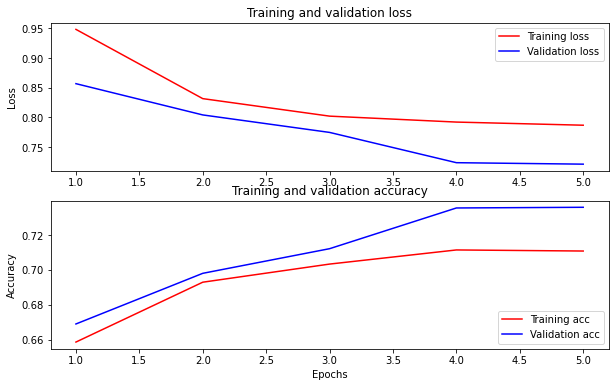

In [23]:
# agora vamos verificar graficamente os resultados

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [24]:
# agora vamos salvar o modelo para poder submeter no Kaggle
model.save('saved_model_inception/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model_inception/my_model\assets


INFO:tensorflow:Assets written to: saved_model_inception/my_model\assets


após submissão no Kaggle esse foi o resultado de nossa acurácia. que foi uma melhor acurácia de antes, de outro modelo que utilizei, onde obtive um acerto de 0.67

![](./final_score.png)

